In [21]:
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm, trange
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

from model.flow import FlowNet
from utils.dataloader import SceneDataset, scene_collate

In [14]:
device = 'cuda:0'
train_data_path = "data/eth_ucy/pickles/ynet_processed/zara2_train.pkl"
val_data_path = "data/eth_ucy/pickles/ynet_processed/zara2_test.pkl"
homo_mat_path = "data/eth_ucy/homo_mat/"

homo_mat = {}
for scene in [
    "eth",
    "hotel",
    "students001",
    "students003",
    "uni_examples",
    "zara1",
    "zara2",
    "zara3",
]:
    homo_mat[scene] = torch.Tensor(
        np.loadtxt(homo_mat_path + f"{scene}_H.txt")
    )
seg_mask = True

In [19]:
resize = 1
obs_len = 8
pred_len = 12
total_len = 20
batch_size = 8

df_train = pd.read_pickle(train_data_path)
df_val = pd.read_pickle(val_data_path)

train_dataset = SceneDataset(
    df_train, resize=resize, total_len=total_len
)
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    collate_fn=scene_collate,
)
val_dataset = SceneDataset(
    df_val, resize=resize, total_len=total_len
)
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    collate_fn=scene_collate,
)

Prepare Dataset: 100%|██████████| 1/1 [00:00<00:00, 85.90it/s]


In [24]:
lr = 0.01
epochs = 1
model_args = {
    'future_lens': 12,
    'hidden_size': 32,
    'output_sizes': [32, 4]
}

model = FlowNet(**model_args)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [25]:
for epoch in trange(epochs):
    loss = 0
    log_prob_loss = 0
    logabsdet_loss = 0
    # scene
    for batch, (trajectory, meta, scene) in enumerate(train_loader):
        # trajctory
        for i in range(0, len(trajectory), batch_size):
            observed = trajectory[i : i + batch_size, :obs_len, :]       # (batch_size, obs_len, 2)
            gt_future = trajectory[i : i + batch_size, obs_len:]
            
            optimizer.zero_grad()
            log_prob, logabsdet = model(observed, gt_future)
            # Compute NLL Loss
            nll_loss = - torch.mean(log_prob - logabsdet, dim=0)
            nll_loss.backward()
            # Gradient Step
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            
            loss += nll_loss.item()
            log_prob_loss += log_prob.mean().item()
            logabsdet_loss += logabsdet.mean().item()

100%|██████████| 1/1 [01:24<00:00, 84.50s/it]


/home/chenjiahe/miniconda3/envs/flow/lib/python3.10/site-packages/torch/distributions/distribution.py:166: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


torch.Size([8, 8, 2])
torch.Size([8, 12, 2])


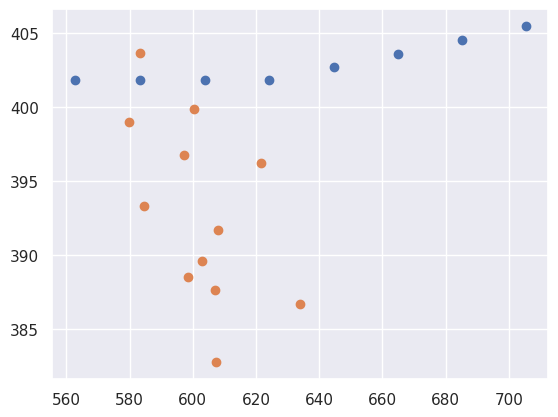

In [43]:
model.eval()
with torch.no_grad():
    for batch, (trajectory, meta, scene) in enumerate(val_loader):
        for i in range(0, len(trajectory), batch_size):
            observed = trajectory[i : i + batch_size, :obs_len, :]       # (batch_size, obs_len, 2)
            gt_future = trajectory[i : i + batch_size, obs_len:]
            
            
            sampled_trajs = model.predict_n(observed, 1)
            # print(observed.shape)
            # print(sampled_trajs.shape)
            # tt = 0
            # observed_test = observed[tt]
            # plt.scatter(observed_test[:, 0], observed_test[:, 1])
            # s = sampled_trajs[tt]
            # plt.scatter(s[:, 0], s[:, 1])
            break
        break

In [ ]:
hist_mu = torch.mean(torch.tensor(train_loader.dataset[0][0]), axis=0)
sampled_trajs = model.predict_n(hist_mu.repeat(1, 1, 1), n=10)
sampled_trajs = sampled_trajs.reshape(10, -1, 2).detach().numpy()
# train_loader.dataset[0][0]

/home/chenjiahe/miniconda3/envs/flow/lib/python3.10/site-packages/torch/distributions/distribution.py:166: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [ ]:
torch.tensor(train_loader.dataset[0][0]).shape
# plt.plot()
sampled_trajs.shape

(10, 12, 2)

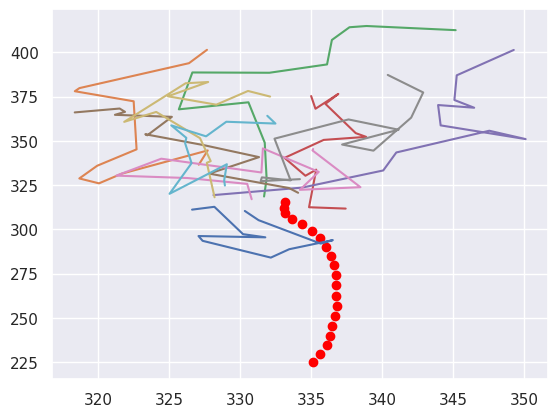

In [ ]:
plt.scatter(hist_mu[:, 0], hist_mu[:, 1], color='red')
for traj in sampled_trajs:
    plt.plot(traj[:, 0], traj[:, 1])
    # break